# Seedbox Data Science Application Test 
## Javier Bosch


In [288]:
# import relevant libraries
import numpy as np
import pandas as pd
import sklearn as sk
from bokeh.plotting import figure
from IPython.display import display, HTML
import os
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

## Objective

Measure the effect of Forcing Users to phone-in to Cancel Service. 

## Assumptions

1. Each sample can click the cancel page numerous times to Cancel. We then observe whether we get a REBILL(1) or NOT(-1). Applies to Control as well.
2. We count the number of Rebills or Chargebacks per sample to determine the distribution of REBILLS. In this case, the distribution of REBILLS includes non-rebills as a negative number. e.g. 5 chargebacks/refunds is equivalent to -5 Rebills. 
3. We assume each transaction is independent of the other and each sample (individual) is independent of each other. 
4. I assume the intention is to observe each users repeated actions in each group. In this case, we are observing the number of rebills per sample and then aggregating this information.

## Read in Data

1. Combine two CSVs.
2. Set binary variables for transaction type REBILL = 1, CHARGEBACKS,REFUND=-1 
3. 1 and -1 will allow for easier aggregation of the transaction types and combine the rebills (positive) and nonrebills(negative) into one distribution of # of rebills in the experiment. 
3. When aggregating, those samples that have a rebill and non-rebill will cancel out and the # of rebills may sum to 0, netting out the effect. This should not affect the results because only 8 samples have both rebills and chargebacks. 

In [95]:
# Read in data and combine dataframes
samples_df = pd.read_csv('datasciencetest/testSamples.csv', sep = ',', header =0)
trans_df = pd.read_csv('datasciencetest/transData.csv', sep=',', header = 0)
df = pd.merge(trans_df, samples_df, on='sample_id')
df['types']=df['transaction_type'].apply(lambda x : 1 if x =='REBILL' else -1)
HTML(df.head().to_html())
# HTML(samples_df.head().to_html())

,transaction_id,sample_id,transaction_type,transaction_amount,test_group,types
0,52346326,11,REBILL,24.95,1,1
1,52346327,11,REBILL,24.95,1,1
2,52346328,32,REBILL,29.95,1,1
3,52346329,32,REBILL,29.95,1,1
4,52346330,32,REBILL,29.95,1,1


In [96]:
# Separate Groups
control_df= df[df['test_group']==0]
test_df = df[df['test_group']==1]

# some summary statistics to get an idea for the data. 
tot_rebills_control = control_df[control_df['types']==1].types.count()
tot_control = control_df.types.count()
tot_rebills_test = test_df[test_df['types']==1].types.count()
tot_test = test_df.types.count()
total_ids = samples_df.sample_id.count()
total_test_ids=samples_df.test_group.sum()
total_control_ids = total_ids - total_test_ids
print('There are {0} control transactions. \nThere are {1} test transactions.'.
      format(tot_control,tot_test))
perc_rebill_control, perc_rebill_test = tot_rebills_control/tot_control*100, tot_rebills_test/tot_test*100
print('There are {0:.2f}% rebills in the control and {1:.2f}% rebills in the test group.'.format(perc_rebill_control,perc_rebill_test))
print('There are {0:.2f}% non-rebills in the control and {1:.2f}% non-rebills in the test group.'.format(100-perc_rebill_control,100-perc_rebill_test))
print('There are {} persons in control group and {} persons in the test group'.format(total_control_ids,total_test_ids))

There are 4050 control transactions. 
There are 3380 test transactions.
There are 92.74% rebills in the control and 94.82% rebills in the test group.
There are 7.26% non-rebills in the control and 5.18% non-rebills in the test group.
There are 44886 persons in control group and 14835 persons in the test group


These statistics simply tell us that there are more rebills than nonrebills (chargebacks and refunds). 

It also appears that given there are only 4050 transactions from the control group with more persons in the control group than the test group, there will be far less recurring transactions per person or more likely for each person to have only one transaction. 

The data in the control and test groups do not appear to represent each other in similar ways given that there are less people in the test with more possible transactions per person. 


## Distribution of Rebills for the Control and Test Groups 

note: Rebills less than 1 represent chargebacks/refunds

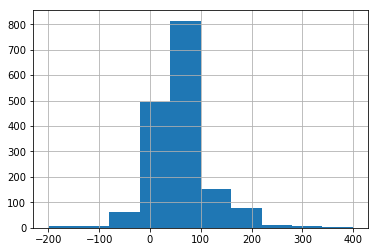

In [269]:
test_df.groupby('sample_id').sum().transaction_amount.hist()

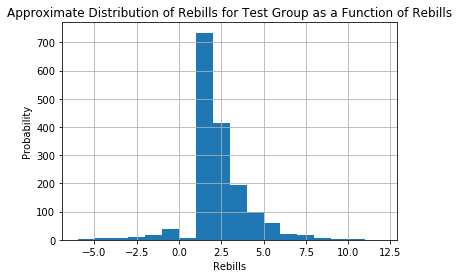

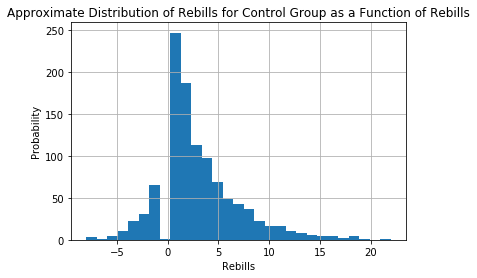

In [289]:
bins_control = control_df.groupby(by ='sample_id').sum()['types'].value_counts().count()
bins_test = test_df.groupby(by ='sample_id').sum()['types'].value_counts().count()
norm = False

# Test Group histogram for # Rebills 
hist_rebills = test_df.groupby(by ='sample_id').sum()['types']
hist_rebills.hist(bins=bins_test,normed=norm)
plt.title('Approximate Distribution of Rebills for Test Group as a Function of Rebills')
plt.xlabel('Rebills')
plt.ylabel('Probability')
plt.show() 

# Control Group histogram for # of Rebills
hist_rebills= control_df.groupby(by ='sample_id').sum()['types']
# hist_control_rebills['types'].max()*2
hist_rebills.hist(bins=bins_control, normed = norm)
plt.title('Approximate Distribution of Rebills for Control Group as a Function of Rebills')
plt.xlabel('Rebills')
plt.ylabel('Probability') 
plt.show()

test_EV_rebills = round(test_df.groupby(by ='sample_id').sum()['types'].mean())
test_var_rebills = test_df.groupby(by ='sample_id').sum()['types'].var(ddof =1)
control_EV_rebills = round(control_df.groupby(by ='sample_id').sum()['types'].mean())
control_var_rebills = test_df.groupby(by ='sample_id').sum()['types'].var(ddof=1)

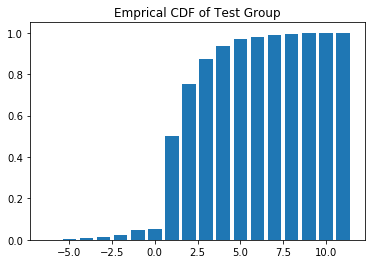

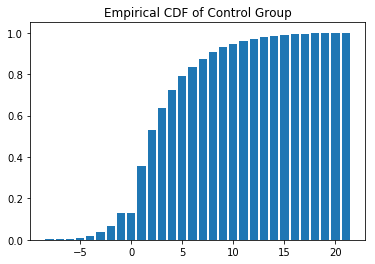

In [203]:
## Histogram and Emprical CDF of the test and control group
test_prob_hist, test_bin_values = np.histogram(test_df.groupby('sample_id').sum()['types'], bins = test_df.groupby(by ='sample_id').sum()['types'].value_counts().count(), normed = True)

control_prob_hist, control_bin_values = np.histogram(control_df.groupby('sample_id').sum()['types'], bins = control_df.groupby(by ='sample_id').sum()['types'].value_counts().count()+1, normed = True)

test_cdf = np.cumsum(test_prob_hist)
test_cdf = pd.DataFrame(data = [test_bin_values[0:len(test_bin_values)-1].T,test_cdf.T]).T
test_cdf.columns=['x','F']

control_cdf = np.cumsum(control_prob_hist)
control_cdf = pd.DataFrame(data = [control_bin_values[0:len(control_bin_values)-1].T,control_cdf.T]).T
control_cdf.columns=['x','F']

#Checks
# print(test_cdf)
# print(control_cdf)
# print(test_bin_values)
# print(test_prob_hist)

plt.bar(test_cdf['x'],test_cdf['F'])
plt.title('Emprical CDF of Test Group')
plt.show()
plt.bar(control_cdf['x'], control_cdf['F'])
plt.title('Empirical CDF of Control Group')

## 1. The Approximate Distribution of the Control and Test Group

From the observation of the aggregated data, it appears that both groups follow a normal distribution centered primarily around 1 Rebill on average. The test group appears to be tighter and skewed to the right can could probably be fit by a lognormal distribution. 

We will try to run some tests to determine if the means and variances is different. 

From visual observation it appears that Forcing users to callin, on average the likelihood of a refund or chargeback is lower than using the webform. 

Also, there appears to be more frequent Rebills of 1 to 2 rebills in the test group but the control group distribution is fatter to the right which indicates a higher chance of more frequent rebills greater than 1 or 2.  



## 2. The Likelihood of getting at least 1 Rebill per person is:  

$$ P(X >= 1)  = 1 - P(X < 1) $$

In [221]:
# Prob of at least 1 Rebill. 

x_lessthan_1= test_cdf[test_cdf['x']==0]['F']
prob = 1 - x_lessthan_1.values[0]
print('The likelihood of getting at least 1 Rebill in the test group is: {:.2f}%'.format(prob*100)) 

x_lessthan_1= control_cdf[control_cdf['x']==0]['F']
prob = 1 - x_lessthan_1.values[0]
print('The likelihood of getting at least 1 Rebill in the control group is: {:.2f}%'.format(prob*100)) 
print('From the empirical distribution, it appears that it is more likely to get at least 1 rebill in the test = phone-in group')

The likelihood of getting at least 1 Rebill in the test group is: 94.80%
The likelihood of getting at least 1 Rebill in the control group is: 87.12%
From the empirical distribution, it appears that it is more likely to get at least 1 rebill in the test = phone-in group


## 2. Expected Transaction Amount per Person. 

In [241]:
bins_test_transac = test_df.groupby('sample_id').sum()['transaction_amount'].value_counts().count()
bins_control_transac = control_df.groupby('sample_id').sum()['transaction_amount'].value_counts().count()

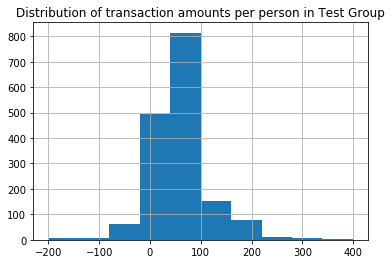

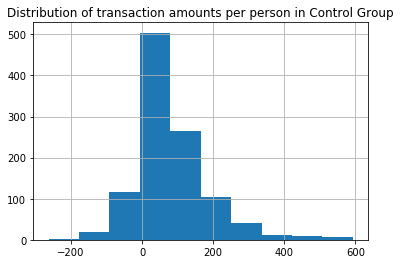

The Expected Value of the transaction amount for the Test Group is:58.36911314984639
The Expected Value of the transaction amount for the Control Group is:83.26126042632048
It appears that the control group will generate more revenue on average per person


In [276]:
transac_test_df = test_df.groupby('sample_id').sum().transaction_amount
transac_control_df = control_df.groupby('sample_id').sum().transaction_amount
transac_test_df.hist()
plt.title('Distribution of transaction amounts per person in Test Group')
plt.show()
transac_control_df.hist()
plt.title('Distribution of transaction amounts per person in Control Group')
plt.show()

print('The Expected Value of the transaction amount for the Test Group is:{}'.format(transac_test_df.mean()))
print('The Expected Value of the transaction amount for the Control Group is:{}'.format(transac_control_df.mean()))
print('It appears that the control group will generate more revenue on average per person')


## Those were the persons who have rebills and nonrebills (Chargebacks or Refunds.) Chargeback rates

This will cancel out the effect when counting number of rebills, but this should not affect the intention of the experiment and the results as we are aggergating the number of rebills. 

In [278]:
t = test_df.groupby(by = ['sample_id', 'types']).count()
x = t.index.get_level_values(0)
z = x[x.duplicated()].tolist()
test_df[test_df['sample_id'].isin(z)].sort_values(['sample_id', 'transaction_id'])


,transaction_id,sample_id,transaction_type,transaction_amount,test_group,types
869,52347195,7338,REBILL,29.95,1,1
870,52347196,7338,CHARGEBACK,-29.95,1,-1
1867,52348193,15909,REBILL,24.95,1,1
1868,52348194,15909,CHARGEBACK,-24.95,1,-1
2024,52348350,17305,REBILL,24.95,1,1
2025,52348351,17305,REBILL,24.95,1,1
2026,52348352,17305,REBILL,24.95,1,1
2027,52348353,17305,CHARGEBACK,-24.95,1,-1
2028,52348354,17305,CHARGEBACK,-24.95,1,-1
3083,52349409,25114,REBILL,24.95,1,1


Assigning the types to 1 and -1 and summing them would not have any sizeable effect on the test group. 

Running a similar query on the control dataframe will show similar results, if not less.  




## Significance of the Differences in Mean. 

We will use a ttest given the difference in sample sizes, and approximation to the normal. 



In [307]:
def ttest(mean1,mean2,var1,var2, n1,n2):
    s_p = ((n1-1)*var1 +(n2-2)*var2)/(n1+n2-2)
    t_stat = (mean1-mean2)/(s_p*np.sqrt((1/n1)+(1/n2)))
    return t_stat

In [323]:
test_EV_rebills = test_df.groupby(by ='sample_id').sum()['types'].mean()
test_var_rebills = test_df.groupby(by ='sample_id').sum()['types'].std()
control_EV_rebills = control_df.groupby(by ='sample_id').sum()['types'].mean()
control_var_rebills = test_df.groupby(by ='sample_id').sum()['types'].std()
tstat = ttest(test_EV_rebills,control_EV_rebills,test_var_rebills,control_var_rebills,total_test_ids,total_control_ids)
df = total_test_ids + total_control_ids -2 

p_value = 1 - stats.t.cdf(tstat,df = 50000)
print(p_value)

1.0


'We can say that the number of rebills on average are not different from each other'

In [326]:
print('Is there a statistical difference in the means of the transaction amounts')

tstat = ttest(transac_test_df.mean(),transac_control_df.mean(), transac_test_df.var(),transac_control_df.var(), total_test_ids,total_control_ids)
p_val = 1-stats.t.cdf(tstat,df=5000)
print('p-value: ',p_val)

print('We cannot determine that there is a significant difference between the revenue')

Is there a statistical difference in the means of the transaction amounts
p-value:  0.618308437988
We cannot determine that there is a significant difference between the revenue


On average, the likelihood of a higher chargebacks rates are larger for the test group than the control, however there is also not a statistically significant difference between the control and test group. chargebacks/rebills for users approach 0 on average for the sample sizes observed for the test and control. 